In [1]:
import librosa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torchmetrics
import os
import warnings
from IPython.display import Audio
warnings.filterwarnings('ignore')
device = torch.device('cpu')

In [2]:
# config
class Config:
    SR = 16000
    N_MFCC = 70
    N_MELS = 70
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 32
    N_EPOCHS = 15
    LR = 0.0001
    MAX_DURATION = 5 # 최대 시간, 초
    SEED = 42
    PAD_SIZE = MAX_DURATION * SR # 패딩 후 크기 설정 = 샘플 수
    
CONFIG = Config()

In [3]:
def seed_everything(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED)

### 데이터 읽기, 데이터 확인 작업

In [4]:
df = pd.read_csv('./train.csv')
X_train, X_val, y_train, y_val = train_test_split(df, df['label'], test_size=0.35, random_state=CONFIG.SEED)

In [5]:
X_train.head()

,id,path,label
26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake


In [6]:
X_val.head()

,id,path,label
49798,PUOXNOKJ,./train/PUOXNOKJ.ogg,real
54292,GXOIPDJP,./train/GXOIPDJP.ogg,fake
40359,FOEQKPPR,./train/FOEQKPPR.ogg,fake
50441,IYASAVDT,./train/IYASAVDT.ogg,real
37723,VLWIXPTC,./train/VLWIXPTC.ogg,real


In [7]:
y_train.head()

26525    real
28922    fake
23673    real
18245    fake
40152    fake
Name: label, dtype: object

In [8]:
y_val.head()

49798    real
54292    fake
40359    fake
50441    real
37723    real
Name: label, dtype: object

In [9]:
X_train_fake = X_train[X_train["label"]=="fake"]
X_train_real = X_train[X_train["label"]=="real"]

In [10]:
X_train_fake.shape, X_train_real.shape
# fake와 real의 수가 거의 균등함을 알 수 있음

((18005, 3), (18029, 3))

In [11]:
#reset_index를 통해 index를 먼저 초기화해줌
X_train_fake = X_train_fake.reset_index()
X_train_real = X_train_real.reset_index()

In [12]:
X_train_fake.head()

,index,id,path,label
0,28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
1,18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
2,40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake
3,54086,XVAYJFQY,./train/XVAYJFQY.ogg,fake
4,18730,YQBNZXBM,./train/YQBNZXBM.ogg,fake


In [13]:
X_train_real.head()

,index,id,path,label
0,26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
1,23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
2,12045,JLOOQDFO,./train/JLOOQDFO.ogg,real
3,35415,ZCDJYRLI,./train/ZCDJYRLI.ogg,real
4,13455,OOOYQBGD,./train/OOOYQBGD.ogg,real


### real data 몇 개 확인해보기

In [ ]:
data = os.path.join("./open",X_train_real["path"][0])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

### fake 데이터 몇 개 확인해보기

In [ ]:
data = os.path.join("./open",X_train_fake["path"][0])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

In [16]:
X_train = X_train.reset_index()
X_val = X_val.reset_index()
y_train = y_train.reset_index()
y_val = y_val.reset_index()

In [17]:
X_train

,index,id,path,label
0,26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
1,28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
2,23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
3,18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
4,40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake
...,...,...,...,...
36029,44732,PWTCAYUB,./train/PWTCAYUB.ogg,fake
36030,54343,HSAHCTUQ,./train/HSAHCTUQ.ogg,real
36031,38158,CXJSUSJK,./train/CXJSUSJK.ogg,fake
36032,860,ZBTGTORE,./train/ZBTGTORE.ogg,real


## 데이터 불러오기

In [18]:
root_dir = "./"

# def add_padding(audio):
#     if len(audio) < CONFIG.PAD_SIZE:
#         audio = np.pad(audio, (0, CONFIG.PAD_SIZE - len(audio)), mode='constant')
#     else:
#         audio = audio[:CONFIG.PAD_SIZE]
#     return audio
def load_audio(df, root_dir):
    audios = []
    for i in tqdm(range(df.shape[0])):
        file_path = os.path.join(root_dir, df["path"][i])
        audio, sample_rate = librosa.load(file_path, sr=Config.SR)
        # audio = add_padding(audio)
        audio_np = np.array(audio)
        audios.append(audio_np)
    return audios

In [19]:
train_audios = load_audio(X_train, root_dir)
train_audios

100%|████████████████████████████████████████████████████████████████████████████| 36034/36034 [10:23<00:00, 57.78it/s]


[array([-0.03493401, -0.04720392, -0.03905734, ...,  0.01794783,
         0.05836653, -0.05124343], dtype=float32),
 array([0.07633661, 0.1311382 , 0.13844413, ..., 0.01983431, 0.02201   ,
        0.02347231], dtype=float32),
 array([ 0.06589692,  0.0761763 ,  0.04328509, ..., -0.04746609,
        -0.05008017, -0.04353867], dtype=float32),
 array([ 0.0687969 ,  0.09404162,  0.0778709 , ..., -0.02310466,
        -0.00310481,  0.01110373], dtype=float32),
 array([-0.05460778, -0.08416761, -0.08133532, ..., -0.07087424,
        -0.07487662, -0.06106302], dtype=float32),
 array([-0.02175857, -0.02967844, -0.02098274, ...,  0.03131709,
         0.03239249,  0.028803  ], dtype=float32),
 array([-0.05140394, -0.05278514, -0.04631227, ..., -0.04852442,
        -0.05393557, -0.04563741], dtype=float32),
 array([-0.02569563, -0.03855547, -0.03831382, ..., -0.04679772,
        -0.05429097, -0.04330054], dtype=float32),
 array([-0.02391773, -0.04191151, -0.05378082, ...,  0.04657521,
         0.05

In [20]:
val_audios = load_audio(X_val, root_dir)
val_audios

100%|████████████████████████████████████████████████████████████████████████████| 19404/19404 [05:57<00:00, 54.31it/s]


[array([-0.03737227, -0.05328577, -0.04432795, ..., -0.07469565,
         0.00280151,  0.05485187], dtype=float32),
 array([ 0.04961466,  0.06770548,  0.04615535, ..., -0.02304168,
        -0.0409341 , -0.03249143], dtype=float32),
 array([ 0.05045838,  0.06760503,  0.05309918, ..., -0.02540854,
        -0.03643021, -0.03837001], dtype=float32),
 array([-0.05353406, -0.08090333, -0.06931115, ...,  0.03473306,
         0.03267439, -0.07167754], dtype=float32),
 array([ 0.01824374,  0.00263109, -0.00052647, ...,  0.00791699,
        -0.02162658, -0.04938579], dtype=float32),
 array([ 0.07024919,  0.09440652,  0.07451238, ..., -0.03311045,
        -0.03645565, -0.03425208], dtype=float32),
 array([-0.05659115, -0.09358966, -0.10386842, ...,  0.01054342,
        -0.0350103 ,  0.04348439], dtype=float32),
 array([ 0.09881341,  0.08199671, -0.11668937, ..., -0.02790711,
         0.00236803,  0.03524268], dtype=float32),
 array([ 0.10107157,  0.14578599,  0.12952627, ..., -0.04657139,
       

In [21]:
import numpy as np

def pad_audio(audio, target_length):
    if len(audio) < target_length:
        pad_width = target_length - len(audio)
        left = pad_width // 2
        right = pad_width - left
        padded_audio = np.pad(audio, (left, right), mode='constant')
    else:
        padded_audio = audio[:target_length]
    return padded_audio

target_length = 16000*5
train_audios_padded = [pad_audio(audio, target_length) for audio in train_audios]
val_audios_padded = [pad_audio(audio, target_length) for audio in val_audios]

## Melspectrogram, mfcc

In [22]:
def extract_feature(audios, mfcc=True):
    features = []
    if mfcc: #mfcc로 피처를 추출하고 싶을 때
        for audio in tqdm(audios):
            mfcc_feature = librosa.feature.mfcc(y=audio, sr=CONFIG.SR, n_mfcc=CONFIG.N_MFCC)
            mfcc_feature = np.mean(mfcc_feature.T, axis=0)
            features.append(mfcc_feature)
    else: #mel로 피처 추출하고 싶을 때
        for audio in tqdm(audios):
            mel_feature = librosa.feature.melspectrogram(y=audio, sr=CONFIG.SR, n_mels=CONFIG.N_MELS)
            mel_feature = librosa.power_to_db(mel_feature, ref=np.max)
            features.append(mel_feature)
    return np.array(features)

In [ ]:
mfcc_X_train_features = extract_feature(train_audios_padded, mfcc=True)
mfcc_X_val_features = extract_feature(val_audios_padded, mfcc=True)

In [ ]:
np.save('./0702/mfcc_X_train_features', mfcc_X_train_features)
np.save('./0702/mfcc_X_val_features', mfcc_X_val_features)

In [23]:
mfcc_X_train_features = np.load('./0702/mfcc_X_train_features.npy')
mfcc_X_val_features = np.load('./0702/mfcc_X_val_features.npy')

In [24]:
mfcc_X_train_features

array([[-2.28498215e+02,  5.18411674e+01,  2.15411873e+01, ...,
         1.26461506e+00, -1.07576191e-01,  1.29132450e+00],
       [-4.44394409e+02,  4.80738983e+01, -1.38015118e+01, ...,
        -3.20793986e-01, -3.95428836e-01, -9.18091595e-01],
       [-2.23456512e+02,  9.07367935e+01,  1.75330315e+01, ...,
        -4.87885207e-01, -2.45833898e+00, -2.00437456e-01],
       ...,
       [-3.52954865e+02,  5.20684395e+01,  1.14392910e+01, ...,
         1.16817206e-01,  1.03860867e+00,  2.86855906e-01],
       [-2.61748016e+02,  1.14076508e+02, -8.96130943e+00, ...,
        -3.00379336e-01,  4.09081221e-01,  1.38831747e+00],
       [-4.26235626e+02,  2.31165867e+01,  2.19583154e+00, ...,
        -8.25943425e-02, -2.88920254e-01,  8.36134851e-02]], dtype=float32)

In [25]:
print("mfcc_X_train_features.shape",mfcc_X_train_features.shape)
#((47122, 13)): (샘플 수, mfcc 계수)
print("mfcc_X_val_features.shape",mfcc_X_val_features.shape)

mfcc_X_train_features.shape (36034, 70)
mfcc_X_val_features.shape (19404, 70)


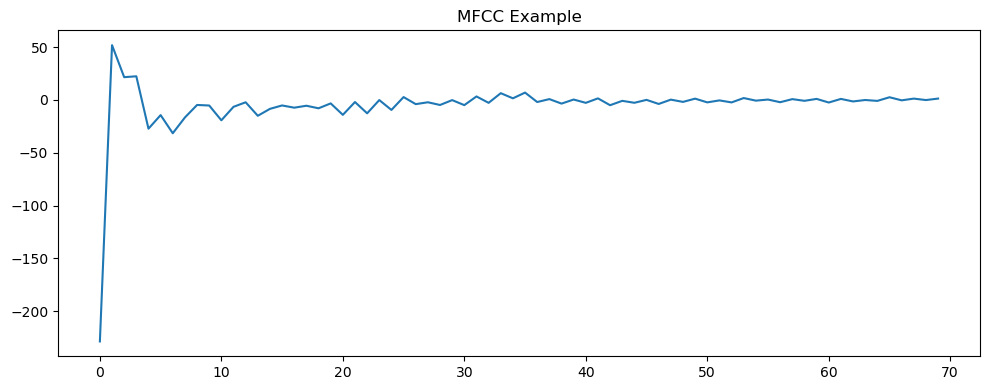

In [26]:
import matplotlib.pyplot as plt

# Mel-spectrogram 시각화
def plot_mel_spectrogram(mel_spectrogram, title='Mel-Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    
# MFCC 시각화
def plot_mfcc(mfcc, title='MFCC'):
    plt.figure(figsize=(10, 4))
    plt.plot(mfcc)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 예시 Mel-spectrogram 시각화
#plot_mel_spectrogram(mel_X_train_features[0], title='Mel-Spectrogram Example')

# 예시 MFCC 시각화
plot_mfcc(mfcc_X_train_features[0], title='MFCC Example')


### 모델 생성

In [ ]:
!pip install tensorflow==2.16.1
!pip install keras==3.0.0

In [102]:
!pip install --upgrade tensorflow

  Using cached tensorflow-2.16.2-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
Using cached tensorflow-2.16.2-cp311-cp311-win_amd64.whl (2.1 kB)
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/377.0 MB 15.2 MB/s eta 0:00:25
   ---------------------------------------- 0.9/377.0 MB 11.6 MB/s eta 0:00:33
   ---------------------------------------- 1.5/377.0 MB 12.0 MB/s eta 0:00:32
   ---------------------------------------- 2.0/377.0 MB 11.8 MB/s eta 0:00:32
   ---------------------------------------- 2.4/377.0 MB 10.9 MB/s eta 0:00:35
   ---------------------------------------- 2.6/377.0 MB 9.8 MB/s eta 0:00:39
   ---------------------------------------- 3.0/377.0 MB 9.7 MB/s eta 0:00:39
   ---------------------------------------- 3.6/377.0 MB 10.0 MB/s eta 0:00:38
   ---------------------------------------- 4.1/377.0 MB 10.1 MB/s eta 0:00:37
   ---------------------------------------- 4.7/377.0 MB 10.4 MB/s eta 0:00:3

In [87]:
!pip install --upgrade keras

  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.0.0
    Uninstalling keras-3.0.0:
      Successfully uninstalled keras-3.0.0


In [27]:
import tensorflow as tf

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [30]:
y_train_encoded = pd.get_dummies(data=y_train, columns=["label"], prefix=["labels"], dtype=float)
y_val_encoded = pd.get_dummies(data=y_val, columns=["label"], prefix=["labels"], dtype=float)

In [31]:
y_train_encoded = y_train_encoded[["labels_fake","labels_real"]]
y_val_encoded = y_val_encoded[["labels_fake","labels_real"]]

In [32]:
y_train_encoded.shape, y_val_encoded.shape

((36034, 2), (19404, 2))

In [33]:
def inference(model, test_dataset):
    predictions = []
    for features in tqdm(test_dataset):
        probs = model(features, training=False)
        predictions.extend(probs.numpy().tolist())
    return predictions

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Activation, LSTM, Reshape
from tensorflow.keras.layers import Bidirectional

def mfcc_cnn_lstm(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    # LSTM 
    # model.add(LSTM(64, return_sequences=True))
    # model.add(LSTM(64))  
    # 결과: 0.39317 -> cnn만을 사용했을 때보다 0.03정도 낮아짐
    
    #LSTM 대신 BiLstm으로 교체해봄 0.3792214873	
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape_mfcc = (13, 1)  # (timesteps, features)
num_classes = CONFIG.N_CLASSES

model2 = mfcc_cnn_lstm(input_shape_mfcc, num_classes)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# 데이터 변환 (timesteps, features) 형태로
mfcc_X_train_features_reshaped = mfcc_X_train_features.reshape(mfcc_X_train_features.shape[0], mfcc_X_train_features.shape[1], 1)
mfcc_X_val_features_reshaped = mfcc_X_val_features.reshape(mfcc_X_val_features.shape[0], mfcc_X_val_features.shape[1], 1)

hist = model2.fit(mfcc_X_train_features_reshaped, y_train_encoded, 
                 validation_data=(mfcc_X_val_features_reshaped, y_val_encoded), 
                 epochs=10, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 646s 563ms/step - accuracy: 0.7865 - loss: 0.4511 - val_accuracy: 0.6653 - val_loss: 0.6706
Epoch 2/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 614s 544ms/step - accuracy: 0.8752 - loss: 0.3117 - val_accuracy: 0.7510 - val_loss: 0.4973
Epoch 3/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 599s 532ms/step - accuracy: 0.8902 - loss: 0.2737 - val_accuracy: 0.8056 - val_loss: 0.4220
Epoch 4/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 581s 515ms/step - accuracy: 0.9006 - loss: 0.2496 - val_accuracy: 0.7726 - val_loss: 0.4861
Epoch 5/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 550s 488ms/step - accuracy: 0.9060 - loss: 0.2382 - val_accuracy: 0.8652 - val_loss: 0.3254
Epoch 6/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 561s 497ms/step - accuracy: 0.9125 - loss: 0.2248 - val_accuracy: 0.8044 - val_loss: 0.4533
Epoch 7/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 564s 500ms/step - accuracy: 0.9147 - loss: 0.2201 - val_accuracy: 0.8135 - val_loss: 0.4200
Epoch 8/10
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 561s 498ms/step - ac

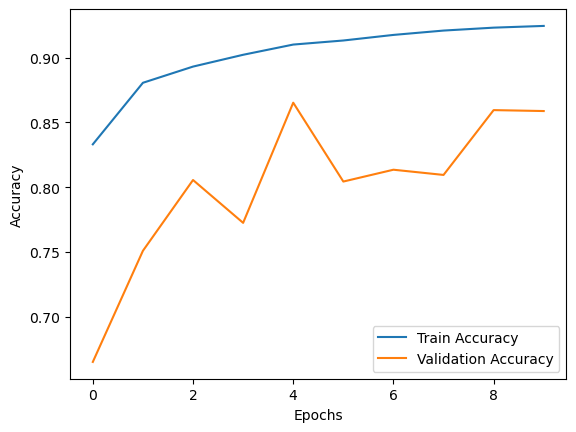

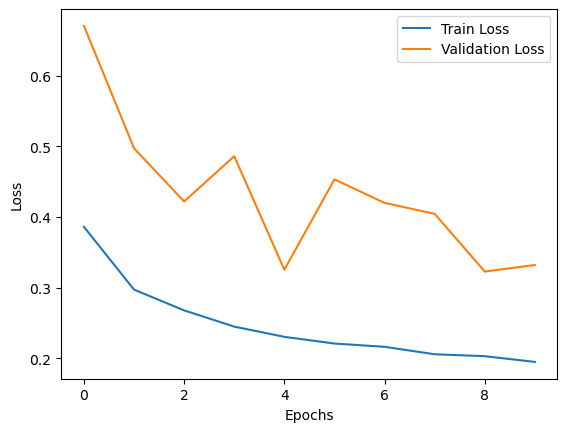

In [37]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
test = pd.read_csv('./test.csv')
print(test.head())

test = load_audio(test, root_dir)

test_mfcc = extract_feature(test, mfcc=True)

           id                   path
0  TEST_00000  ./test/TEST_00000.ogg
1  TEST_00001  ./test/TEST_00001.ogg
2  TEST_00002  ./test/TEST_00002.ogg
3  TEST_00003  ./test/TEST_00003.ogg
4  TEST_00004  ./test/TEST_00004.ogg


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [32:31<00:00, 25.62it/s]


In [39]:
np.save('./0702/mfcc_test_features.npy', test_mfcc)

In [40]:
import tensorflow as tf

test_dataset = tf.data.Dataset.from_tensor_slices(test_mfcc).batch(CONFIG.BATCH_SIZE)

In [41]:
preds = inference(model2, test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [10:59<00:00,  2.37it/s]


In [42]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

,id,fake,real
0,TEST_00000,0.053554,0.946446
1,TEST_00001,0.068749,0.931251
2,TEST_00002,0.150095,0.849905
3,TEST_00003,0.491113,0.508887
4,TEST_00004,0.010117,0.989883


In [44]:
submit.to_csv('./mfcc_bilstm_2.csv', index=False)